In [1]:
!pip install matplotlib
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [5]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\2b01b558-fa04-11ee-b29b-00933761849b.jpg'

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(35)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(35)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(35)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\7ad112e8-811d-11ee-a87a-00933761849b.jpg'


In [12]:
def preprocess(file_path):
    #read image from the passed file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #preprocessing step- resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    #scale the image to be between 0  and 1
    img = img/255.0
    #return our image
    return img

In [13]:
img = preprocess('data\\anchor\\7ad112e8-811d-11ee-a87a-00933761849b.jpg')

In [14]:
img.numpy().max()
#here we just make sure that our value does not go past 1

0.7803372

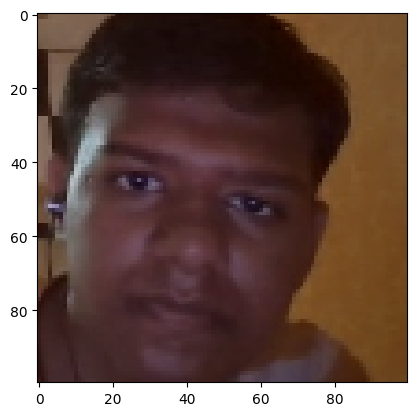

In [16]:
plt.imshow(img)

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
#(anchor,positives) => 1,1,1,1,1
#(anchor,negatives) => 0,0,0,0,0


In [19]:
tf.ones(len(anchor))

<tf.Tensor: shape=(35,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>

In [20]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [21]:
#here the first tf.string will contain the file path to out actual image 
#the second to either the positive or negative image
#and the third will determine whether the prediction was right or not or if they are the same or not

In [22]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [23]:
iterator_labs = class_labels.as_numpy_iterator()

In [24]:
iterator_labs.next()

0.0

In [25]:
samples = data.as_numpy_iterator()

In [26]:
examples = samples.next()

In [27]:
examples

(b'data\\anchor\\e85df8e4-7d3e-11ee-acb5-00933761849b.jpg',
 b'data\\positive\\0d3f09fc-7d3f-11ee-abd9-00933761849b.jpg',
 1.0)

In [28]:
img = preprocess('data\\positive\\0d3f09fc-7d3f-11ee-abd9-00933761849b.jpg')

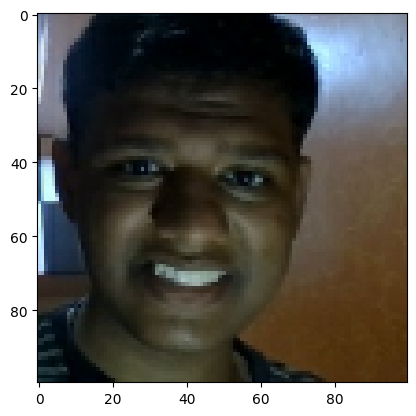

In [30]:
plt.imshow(img)

In [31]:
img2 = preprocess('data\\anchor\\e85df8e4-7d3e-11ee-acb5-00933761849b.jpg')

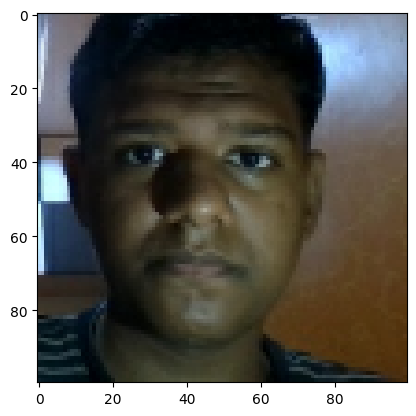

In [32]:
plt.imshow(img2)

In [33]:
#Build train and test partition

def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)
#this function will return by running the preprocess function over the input image and the validation image
#and also return the label  of the process --> 0 or 1

In [35]:
res = preprocess_twin(*examples)
#preprocess everything from examples

In [36]:
preprocess_twin(*examples)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[4.3368000e-01, 5.0905252e-01, 6.1460865e-01],
         [4.0237334e-01, 4.6598116e-01, 5.6852859e-01],
         [4.6219608e-01, 5.0454903e-01, 5.9749019e-01],
         ...,
         [5.1796865e-01, 5.6527066e-01, 6.3105887e-01],
         [5.0674510e-01, 5.5121565e-01, 6.1368465e-01],
         [4.9918267e-01, 5.3447676e-01, 5.9399360e-01]],
 
        [[4.6313411e-01, 5.3560466e-01, 6.5136945e-01],
         [4.1989490e-01, 4.8344159e-01, 5.8734590e-01],
         [4.8521566e-01, 5.2521574e-01, 6.2482351e-01],
         ...,
         [5.2794510e-01, 5.7341182e-01, 6.4535689e-01],
         [5.1157331e-01, 5.5601722e-01, 6.1976469e-01],
         [5.0892073e-01, 5.4442978e-01, 6.1105871e-01]],
 
        [[4.9367058e-01, 5.6542748e-01, 6.9305098e-01],
         [4.2226666e-01, 4.8221177e-01, 5.9861177e-01],
         [5.4011762e-01, 5.7819611e-01, 6.8329412e-01],
         ...,
         [5.3486276e-01, 5.8356869e-01, 6.7286283e-01],


In [37]:
res[0]
#preprocessed image of 100x100x3

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[4.3368000e-01, 5.0905252e-01, 6.1460865e-01],
        [4.0237334e-01, 4.6598116e-01, 5.6852859e-01],
        [4.6219608e-01, 5.0454903e-01, 5.9749019e-01],
        ...,
        [5.1796865e-01, 5.6527066e-01, 6.3105887e-01],
        [5.0674510e-01, 5.5121565e-01, 6.1368465e-01],
        [4.9918267e-01, 5.3447676e-01, 5.9399360e-01]],

       [[4.6313411e-01, 5.3560466e-01, 6.5136945e-01],
        [4.1989490e-01, 4.8344159e-01, 5.8734590e-01],
        [4.8521566e-01, 5.2521574e-01, 6.2482351e-01],
        ...,
        [5.2794510e-01, 5.7341182e-01, 6.4535689e-01],
        [5.1157331e-01, 5.5601722e-01, 6.1976469e-01],
        [5.0892073e-01, 5.4442978e-01, 6.1105871e-01]],

       [[4.9367058e-01, 5.6542748e-01, 6.9305098e-01],
        [4.2226666e-01, 4.8221177e-01, 5.9861177e-01],
        [5.4011762e-01, 5.7819611e-01, 6.8329412e-01],
        ...,
        [5.3486276e-01, 5.8356869e-01, 6.7286283e-01],
        [5.1647055e-01

In [38]:
len(res)

3

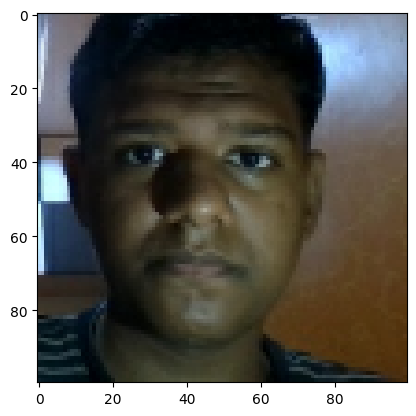

In [39]:
plt.imshow(res[0])

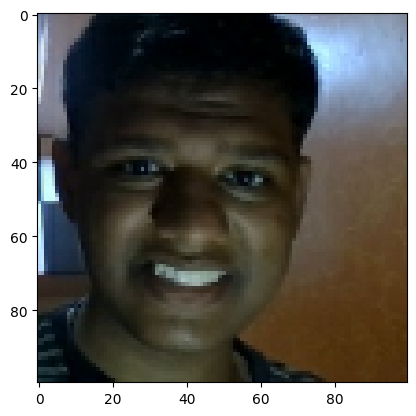

In [40]:
plt.imshow(res[1])

In [41]:
res[2]

1.0

In [42]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
#shuffle because we will have a mix set of samples of positives and negatives in terms of training and testing

In [43]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [44]:
samples = data.as_numpy_iterator()

In [45]:
samples.next()

(array([[[0.40384   , 0.43521255, 0.5254086 ],
         [0.3249396 , 0.3563122 , 0.4403906 ],
         [0.10640785, 0.1377804 , 0.21778041],
         ...,
         [0.46437648, 0.4471216 , 0.47612554],
         [0.4557647 , 0.43443137, 0.4627451 ],
         [0.4646275 , 0.43717653, 0.46756238]],
 
        [[0.35384944, 0.385222  , 0.46757492],
         [0.0897804 , 0.12115294, 0.20350589],
         [0.05372549, 0.08509804, 0.16498825],
         ...,
         [0.45730194, 0.4321569 , 0.46229804],
         [0.46035767, 0.43021333, 0.45835292],
         [0.46629488, 0.4300016 , 0.45249093]],
 
        [[0.11297257, 0.14434512, 0.22669807],
         [0.06425098, 0.09562353, 0.17369412],
         [0.04329411, 0.07466666, 0.14917648],
         ...,
         [0.44039217, 0.40745097, 0.42941177],
         [0.4482353 , 0.40745097, 0.42431372],
         [0.4473647 , 0.40861177, 0.41763917]],
 
        ...,
 
        [[0.5074123 , 0.5598279 , 0.53097284],
         [0.25277698, 0.2940161 , 0.28049

In [46]:
samp = samples.next()


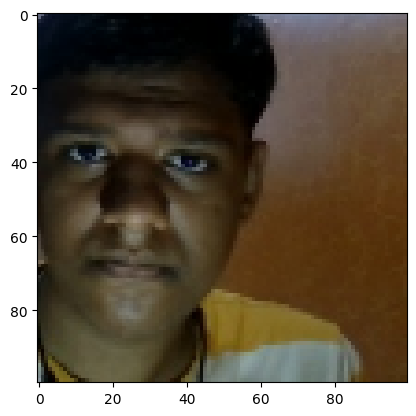

In [47]:
plt.imshow(samp[0])
# anchor image

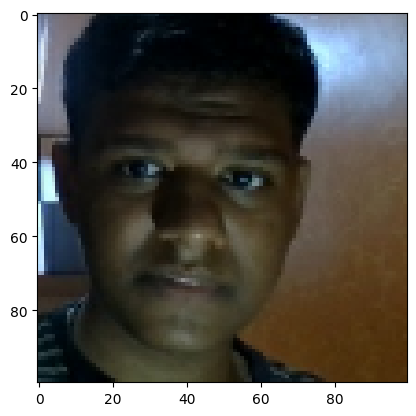

In [49]:
plt.imshow(samp[1])
# validation image

In [50]:
# //as images are same so label should be 1
samp[2]

1.0

In [51]:
round(len(data)*0.7)
#taking around 70% of images

32

In [52]:
#Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

In [53]:
train_samples = train_data.as_numpy_iterator()

In [54]:
train_sample = train_samples.next()

In [55]:
len(train_sample)

3

In [56]:
len(train_sample[0])
#basically it shows the batches of images that we are taking at a time

8

In [57]:
#Testing partition
test_data = data.skip(round(len(data)*0.7))
#skipped the first 70% of training samples so that we do not include that in our testing
test_data = test_data.take(round(len(data) *0.3))
#take the reaminning 30% samples for testing on new images
test_data = test_data.batch(8)
test_data = test_data.prefetch(4)

In [58]:
round(len(data)*0.3)

14

In [59]:
#FEATURE MAPPING PIPELINE
#BUILD EMBEDDING LAYER

def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    #In this case the stride is taken as 1
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [60]:
inp = Input(shape=(100,100,3), name='input_image')

In [61]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [62]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [63]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [64]:
c2

<KerasTensor: shape=(None, 40, 40, 128) dtype=float32 (created by layer 'conv2d_1')>

In [65]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [66]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [67]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [68]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [69]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [70]:
6*6*256
#so 9216 vectors are going to be flattened in our feature vector

9216

In [71]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [72]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [73]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [74]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [75]:
##Build distancce layer

In [76]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Main working happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [77]:
l1 = L1Dist()

In [78]:
l1

In [79]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [80]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [81]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [82]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [83]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [84]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    #so in summary we will see this name pop up
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [85]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [115]:
from tensorflow.keras.callbacks import LearningRateScheduler

#exponential decay
def scheduler(epoch,lr):
    if epoch <= 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    

In [116]:
callback = LearningRateScheduler(scheduler)

In [117]:
#optimizer for backpropagation
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
#In here we can set logits = true by writing:
#BinaryCrossEntropy(fron_logits=true) this is recommended when the inputs to the loss function 
#are not normalized

In [118]:
#ESTABLISHING CHECKPOINTS
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [119]:
test_batch = train_data.as_numpy_iterator()

In [120]:
batch_1 = test_batch.next()

In [121]:
batch_1[0]

array([[[[0.4513302 , 0.47485963, 0.57612705],
         [0.3900157 , 0.4135451 , 0.5088016 ],
         [0.23185885, 0.2577412 , 0.34203923],
         ...,
         [0.46690983, 0.44570985, 0.485702  ],
         [0.4582541 , 0.43662745, 0.4701349 ],
         [0.45815063, 0.43854278, 0.46500707]],

        [[0.41856787, 0.44209728, 0.5361741 ],
         [0.13303058, 0.16267766, 0.25357962],
         [0.05288627, 0.08428235, 0.1641255 ],
         ...,
         [0.4569412 , 0.42956865, 0.46062747],
         [0.45484078, 0.42723292, 0.45452708],
         [0.452     , 0.42723608, 0.4458823 ]],

        [[0.23831375, 0.26733336, 0.35260394],
         [0.07520785, 0.10606275, 0.18867451],
         [0.03647059, 0.06901962, 0.14117648],
         ...,
         [0.43800002, 0.4062353 , 0.4191765 ],
         [0.45030588, 0.4122667 , 0.42089412],
         [0.45677647, 0.41873726, 0.4256235 ]],

        ...,

        [[0.52656513, 0.59415716, 0.5760472 ],
         [0.4702991 , 0.5237342 , 0.5088793 ]

In [122]:
batch_1[2]
#this should give us all the labels

array([1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [123]:
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [124]:
np.array(X).shape
#2 components one is the input/anchor image and the other is either positive or negative image
#8 is the batch size in a single batch
#100x100 is the dimensions
#3 meaning depth is 3 (not a grayscale image)

(2, 8, 100, 100, 3)

In [125]:
#TRAINING STEP
@tf.function
#using tf.function(it is a decorator) we are compiling what is in this train_step function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss


In [126]:
#BUILDING THE TRAINING LOOP
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [127]:
EPOCHS = 40
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
4/4 [==============================] - 56s 13s/step

 Epoch 2/40
4/4 [==============================] - 55s 14s/step

 Epoch 3/40
4/4 [==============================] - 55s 14s/step

 Epoch 4/40
4/4 [==============================] - 54s 14s/step

 Epoch 5/40
4/4 [==============================] - 55s 14s/step

 Epoch 6/40
4/4 [==============================] - 54s 13s/step

 Epoch 7/40
4/4 [==============================] - 54s 14s/step

 Epoch 8/40
4/4 [==============================] - 53s 13s/step

 Epoch 9/40
4/4 [==============================] - 55s 14s/step

 Epoch 10/40
4/4 [==============================] - 54s 13s/step

 Epoch 11/40
4/4 [==============================] - 55s 14s/step

 Epoch 12/40
4/4 [==============================] - 56s 14s/step

 Epoch 13/40
4/4 [==============================] - 55s 14s/st

In [128]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [129]:
#Precision deonstrates what proportions of positive identifications were actually correct. Recall shows what proportion of actual positives were
#identified correctly

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [130]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [131]:
test_var = test_data.as_numpy_iterator().next()

In [132]:
len(test_var)

3

In [133]:
len(test_var[1])

8

In [134]:
test_var[1]

array([[[[4.51620400e-01, 5.06522298e-01, 6.19554520e-01],
         [4.12345111e-01, 4.54032928e-01, 5.66131771e-01],
         [4.60094094e-01, 4.89168614e-01, 5.95686257e-01],
         ...,
         [5.20298064e-01, 5.60298145e-01, 6.26964808e-01],
         [5.06922364e-01, 5.40490985e-01, 6.02257311e-01],
         [5.05366206e-01, 5.35719156e-01, 5.89758277e-01]],

        [[4.84961569e-01, 5.45708299e-01, 6.48668230e-01],
         [4.22639996e-01, 4.68583524e-01, 5.77385128e-01],
         [4.90298033e-01, 5.24854898e-01, 6.21694088e-01],
         ...,
         [5.33513725e-01, 5.73623598e-01, 6.40392244e-01],
         [5.21769404e-01, 5.55372536e-01, 6.21193767e-01],
         [5.09981096e-01, 5.37588894e-01, 6.00296378e-01]],

        [[5.02596080e-01, 5.67372561e-01, 6.69333339e-01],
         [4.27592158e-01, 4.84219611e-01, 5.86180389e-01],
         [5.42509794e-01, 5.83215714e-01, 6.76980436e-01],
         ...,
         [5.44274509e-01, 5.88941216e-01, 6.67019665e-01],
         [

In [135]:
test_var[2]

array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [136]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[8.7493572e-05],
       [9.9999946e-01],
       [9.6453041e-05],
       [9.9999934e-01],
       [9.9999511e-01],
       [9.9997836e-01],
       [3.0488006e-04],
       [9.9998903e-01]], dtype=float32)

In [137]:
#To convert above into a classification output i.e - either 0 or 1
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 1, 0, 1]

In [138]:
y_true

array([0., 1., 0., 1., 1., 1., 0., 1.], dtype=float32)

In [139]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

#the higher the value the better

1.0

In [140]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

#the higher the value the better

1.0

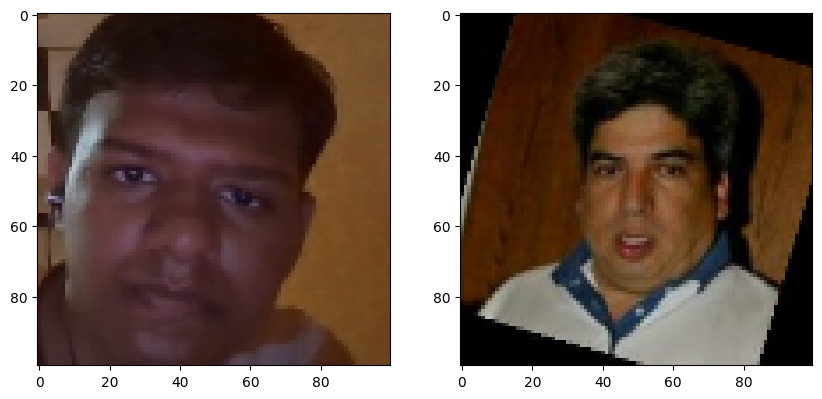

In [146]:
#here we are comparing our results

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])
#the subplot allows you to render plots using a grid like format. The first parameter is the number of rows, the second the number of columns
#and the third value is index

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

#In above array when the value is 0  then the people in front of the camera are not identified and if it is 1 then they are succesfully identified

In [142]:
# Save weights
siamese_model.save('siamesemodelv2.keras')

In [143]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [144]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 801ms/step


array([[8.7493572e-05],
       [9.9999946e-01],
       [9.6453041e-05],
       [9.9999934e-01],
       [9.9999511e-01],
       [9.9997836e-01],
       [3.0488006e-04],
       [9.9998903e-01]], dtype=float32)

In [147]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [148]:
#verification threshold --- 50% > 1
#DETECTION THRESHOLD---  example is if 30 classes of images are above 60% and we had originally taken 50images then 
#Detection metric--- 30/50 = 0.6   (what proportion of verification images are clearing the detection threshold)

In [149]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [150]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 213ms/step
True


In [151]:
np.sum(np.squeeze(results) > 0.5)

23

In [152]:
results

[array([[0.04549726]], dtype=float32),
 array([[0.99173295]], dtype=float32),
 array([[0.99228996]], dtype=float32),
 array([[0.99161994]], dtype=float32),
 array([[0.9922819]], dtype=float32),
 array([[0.9924629]], dtype=float32),
 array([[0.9913497]], dtype=float32),
 array([[0.9914446]], dtype=float32),
 array([[0.99132955]], dtype=float32),
 array([[0.99203384]], dtype=float32),
 array([[0.99157065]], dtype=float32),
 array([[0.9693817]], dtype=float32),
 array([[0.9586818]], dtype=float32),
 array([[0.96155775]], dtype=float32),
 array([[0.94468373]], dtype=float32),
 array([[0.9405939]], dtype=float32),
 array([[0.9526339]], dtype=float32),
 array([[0.9793534]], dtype=float32),
 array([[0.99668974]], dtype=float32),
 array([[0.9965374]], dtype=float32),
 array([[0.99663585]], dtype=float32),
 array([[0.99703616]], dtype=float32),
 array([[0.99494505]], dtype=float32),
 array([[0.99678546]], dtype=float32),
 array([[0.00927702]], dtype=float32),
 array([[0.00864633]], dtype=float3